In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

#sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [50]:
def slope_fork(x_j):
    if x_j >= 0.5:
        return 1
    else:
        return -0.59
    
def update_x(x_j, eps, N_tot):
    x_up = x_j + (slope_fork(x_j) * eps) / N_tot
    if x_up < 1:
        return x_up
    else:
        return 1

def clap(x, w, t, t_clap, sig):
    x = 0
    w = np.random.normal(0, sig) + 1 / (t - t_clap)
    t_clap = t
    return x, w, t_clap

In [51]:
def sim_with_metronome(x_init, w_init, t_clap_init, dt, tmax, metronome_freq=1.0, sig=0.1, eps=0.1, metronome_influence=0.05):

    t = 0.1
    x = x_init
    w = w_init
    t_clap = t_clap_init
    x0_save = []
    
    N = len(w)
    w_save = [[] for i in range(N)]
    t_save = [[] for i in range(N)]
    avg_save = []
    
    metronome_x = 0  #metronome starts at phase 0
    metronome_period = 1 / metronome_freq  # period for one full metronome clap
    
    for entry in range(len(w_save)):
        w_save[entry].append(w[entry])
        t_save[entry].append(t)

    while t < tmax:
        
        # metronome
        metronome_x += dt / metronome_period
        if metronome_x >= 1:
            metronome_x = 0  # reset metronome
            # affects clappers 
            for j in range(len(x)):
                x[j] += metronome_influence * (1 - x[j])  
        
        x = x + w * dt
        index = np.where(x >= 1)[0] 
        
        if len(index) > 0: 
            for i in index:
                x[i] = 0  
                w[i] = np.random.normal(0, sig) + 1 / (t - t_clap[i]) 
                t_clap[i] = t
                
                w_save[i].append(w[i])
                t_save[i].append(t_clap[i])

                for j in range(len(x)):
                    if j != i:
                        x[j] = update_x(x[j], eps, N) 
                    else:
                        continue             

        t += dt
        x0_save.append(x[0])

        if int(t % (dt * 10)) == 0: 
            avg_save.append(np.mean(w))
            
    return w_save, t_save, x0_save, avg_save

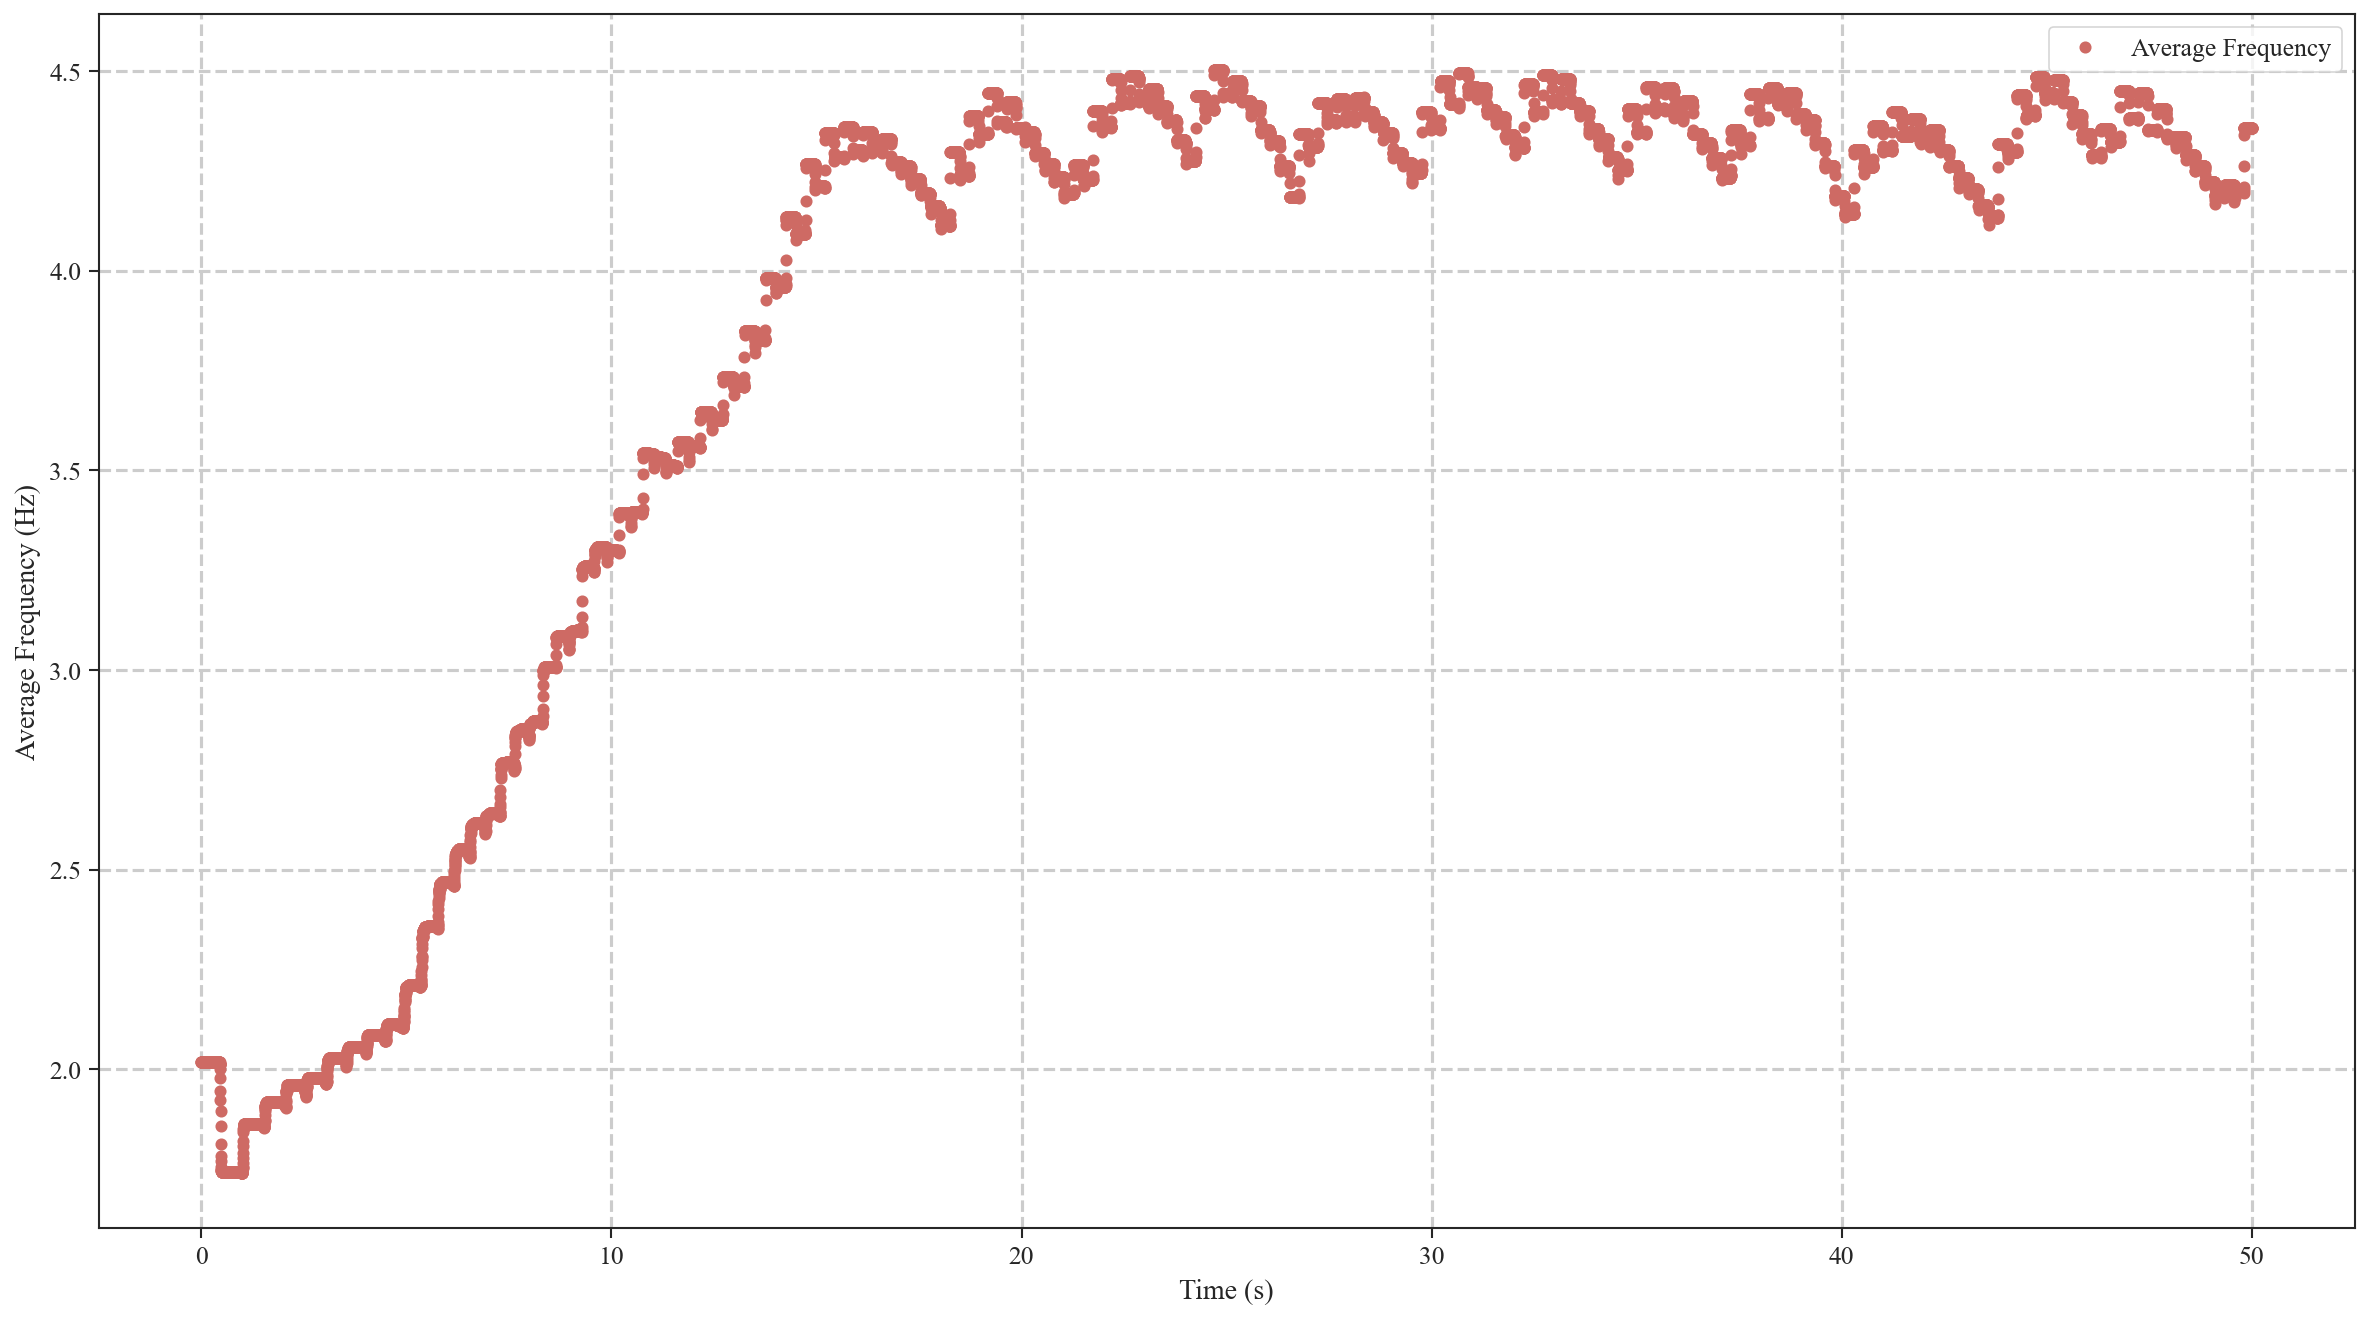

In [52]:
N = 100
w_init = np.random.normal(2, 0.1, N)
x_init = np.zeros(N)
t_clap_init = np.zeros(N)

dt = 0.0025
t_max = 50

# Run the simulation
w_save, t_save, x0_save, avg_save = sim_with_metronome(x_init, w_init, t_clap_init, dt, t_max, metronome_freq=2.0, sig=0.1, eps=0.1, metronome_influence=0.05)

# Plot the average frequency evolution
x1 = np.linspace(0, t_max, len(avg_save))
plt.plot(x1, avg_save, 'o', label='Average Frequency')
plt.xlabel('Time (s)')
plt.ylabel('Average Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()